In [641]:
## IN THIS FILE CAM WILL ATTEMPT TO CODE HIS OWN NEURAL NETWORK!!!!

# import packages
import torch # pytorch
import torch.nn as nn # neural nets
import numpy as np # math
import matplotlib.pyplot as plt # plotting

# SEED
np.random.seed(0)

# Define network
class Heat_PINN(nn.Module):
    def __init__(self,hidden_units):
        super().__init__()
        
        # Parameters
        self.hidden_units = hidden_units # number of nodes in hidden layer
        
        # layers - assume for now tanh activation, but may need to change
        self.net = nn.Sequential(
            nn.Linear(2, hidden_units), # 2 inputs, x and t
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, 1) # 1 output, u
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))


# Function measuring the collocation residual operator using autograd
def heat_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    
    return u_t - u_xx

In [727]:
## Now we will initialize our training data:

def MakeTrainingData(T,L,N_I,N_B,N_L):
    # PDE parameters
    #T = 1 # time domain end
    #L = 1 # domain size -- start w/ 1 but eventually go to [-L,L]
    
    # First set data sizes
    #N_I = 100 #initial condition
    #N_B = 100 #boundary conditions
    #N_L = 1000 #collocation points
    
    # Initial data: function g(x) and time 0
    x_I = torch.linspace(0,1,N_I).reshape(-1,1) # initial x, spaced evenly
    #x_I = torch.rand(N_I).reshape(-1,1) # initial x, sampled randomly
    #x_I = x_I.sort()
    t_I = torch.zeros_like(x_I) # t = 0
    #print(x_I)
    g = torch.sin(np.pi*x_I) # initial data
    #plt.plot(x_I,g) # shows plot of initial data
    
    # Boundary data
    x_B = torch.zeros(N_B).reshape(-1,1) # first half are zeros
    x_B[N_B//2:] = 1 # second half are ones
    #print(x_B)
    t_B = torch.rand(N_B//2,1)*T #one set of t values
    t_B = torch.cat([t_B,t_B],0) #copy twice and put together
    #print(t_B)
    D_B = torch.zeros_like(t_B) # Dirichlet boundary conditions
    #print(D_B)
    
    # Collocation data
    x_L = torch.rand(N_L,1)*L # use for [0,1] or [0,L]
    #x_L = (torch.rand(N_L,1)*2*L)-L # USE IF [-L,L]
    t_L = torch.rand(N_L,1)*T # random time points
    #print(x_L)
    #plt.plot(x_L)

    return x_I, t_I, g, x_B, t_B, D_B, x_L, t_L

In [813]:
## Here we define our loss function

# first set weights for each loss component
w_I = 1
w_B = 1
w_L = 1

## DEFINE ALLOWING FOR ANY SUBSET OF x's TO BE INPUTTED
def Loss(xi,ti,ui,xb,tb,ub,xl,tl,model,p):
    # do initial, boundary, collocation one by one
    # Initial
    u_I = model(xi,ti)
    loss_I = torch.mean((u_I-ui)**2) # MSE for initial data, comparing to g

    # Boundary
    u_B = model(xb,tb)
    loss_B = torch.mean((u_B-ub)**2) # MSE for boundary, comparing to Dirichlet

    # Collocation
    loss_L = torch.mean(heat_residual(model,xl,tl)**2)

    #if p == 1:
    #    print(f"Initial Loss: {loss_I}")
    #    print(f"Boundary Loss: {loss_B}")
    #    print(f"Collocation Loss: {loss_L}")

    # Add up losses, making sure to weight:
    return w_I*loss_I + w_B*loss_B + w_L*loss_L
    

In [757]:
## And now a function for training

# include batches
def train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, print_epochs):
    # INPUTS:
    # model = neural network
    # optimizer = thing running gradient descent, we will use SGD
    # max_epochs = maximum number of iterations
    # tol = error tolerance
    # print_epochs = specifies if we want epochs printed

    T = 1
    L = 1

    x_I, t_I, g, x_B, t_B, D_B, x_L, t_L = MakeTrainingData(T,L,N_I,N_B,N_L) # initiate training data
    print(len(x_I))

    # Set SGD batch sizes
    Nbatch_I, Nbatch_B, Nbatch_L = batch_size_I, batch_size_B, batch_size_L

    for epoch in range(max_epochs):
        # randomize batches
        indices_I = torch.randperm(N_I)[:Nbatch_I]
        xi = x_I[indices_I]
        ti = t_I[indices_I]
        ui = g[indices_I]

        indices_B = torch.randperm(N_B)[:Nbatch_B]
        xb = x_B[indices_B]
        tb = t_B[indices_B]
        ub = D_B[indices_B]

        indices_L = torch.randperm(N_L)[:Nbatch_L]
        xl = x_L[indices_L]
        tl = t_L[indices_L]
        
        
        #outputs = model(X) # Forward pass
        optimizer.zero_grad() # Clear gradients
        loss = Loss(xi,ti,ui,xb,tb,ub,xl,tl,model,print_epochs) # print epochs passes to loss    
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        
        if print_epochs == 1:
            if epoch % (max_epochs // 10) == 0:
                print(f"Epoch [{epoch}/{max_epochs}], Loss: {loss.item():.4f}")

        if loss < tol:
            print(f"Network converged to specified tolerance tol = {tol}")
            print(f"Final epoch: {epoch}")
            break

In [747]:
## RUN TRAINING!!!!!
# initialize model
hidden_units = 100
model = Heat_PINN(hidden_units)

# select an optimizer, will use SGD: 
lr = 1e-3 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr)

# training data parameters
N_I = 100
N_B = 100
N_L = 1000

# training parameters
max_epochs = 10000 # maximum number of iterations
tol = 1e-4 # error tolerance to stop GD before reaching max_epochs
batch_size_I = N_I//10
batch_size_B = N_B//10
batch_size_L = N_L//10



train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, 1)

100
Initial Loss: 0.22585594654083252
Boundary Loss: 0.11860773712396622
Collocation Loss: 0.026881776750087738
Epoch [0/10000], Loss: 0.3713
Initial Loss: 0.03492450714111328
Boundary Loss: 0.00499862153083086
Collocation Loss: 0.004687302280217409
Epoch [1000/10000], Loss: 0.0446
Initial Loss: 0.003973973914980888
Boundary Loss: 0.0011550856288522482
Collocation Loss: 0.007134517654776573
Epoch [2000/10000], Loss: 0.0123
Initial Loss: 0.0011580982245504856
Boundary Loss: 0.00010962002852465957
Collocation Loss: 0.0011107752798125148
Epoch [3000/10000], Loss: 0.0024
Initial Loss: 0.00044915772741660476
Boundary Loss: 7.08665611455217e-05
Collocation Loss: 0.0021834620274603367
Epoch [4000/10000], Loss: 0.0027
Initial Loss: 4.591992910718545e-05
Boundary Loss: 2.6750381948659196e-05
Collocation Loss: 0.0012798428069800138
Epoch [5000/10000], Loss: 0.0014
Initial Loss: 0.00010511731670703739
Boundary Loss: 1.5344932762673125e-05
Collocation Loss: 0.0008974854717962444
Epoch [6000/10000]

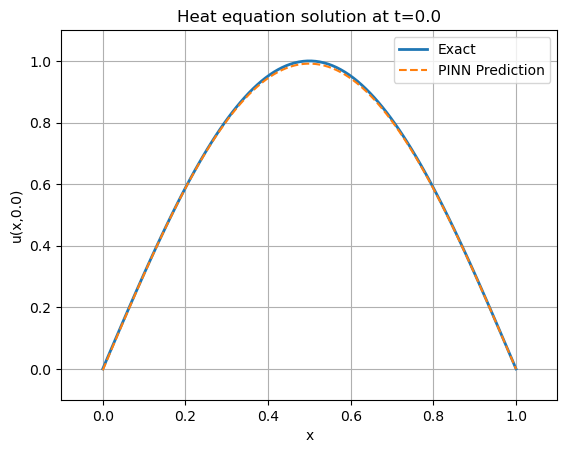

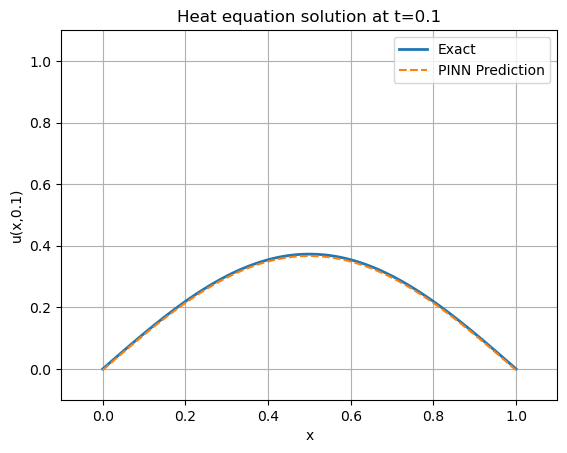

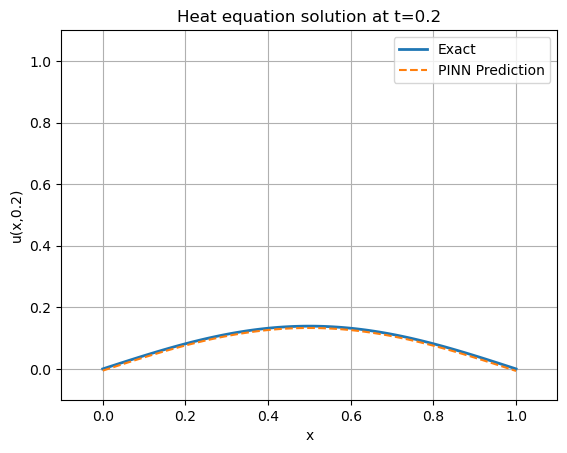

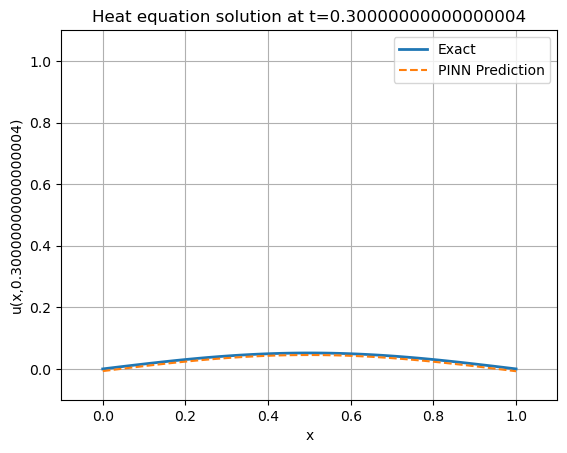

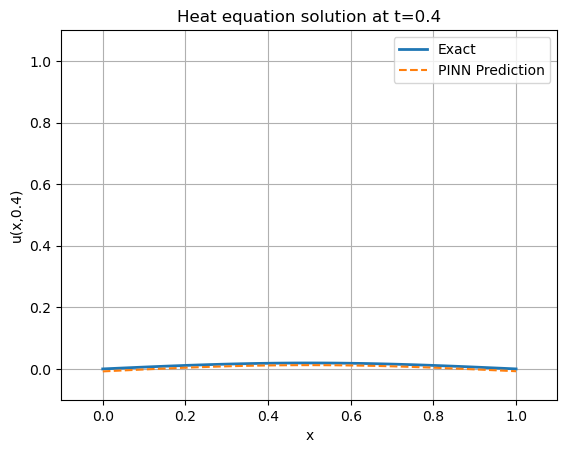

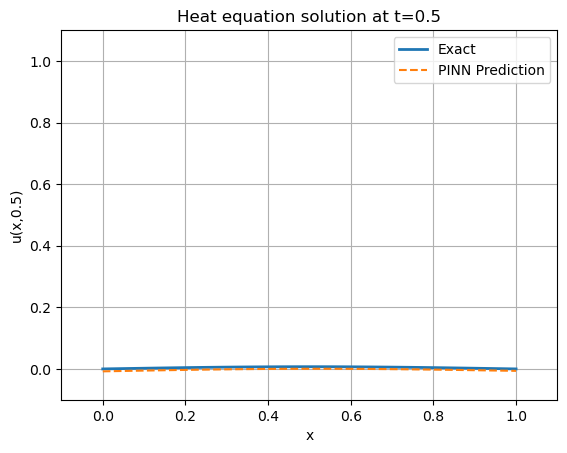

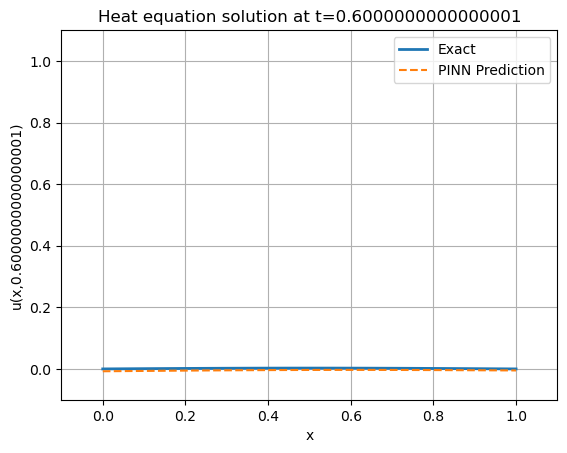

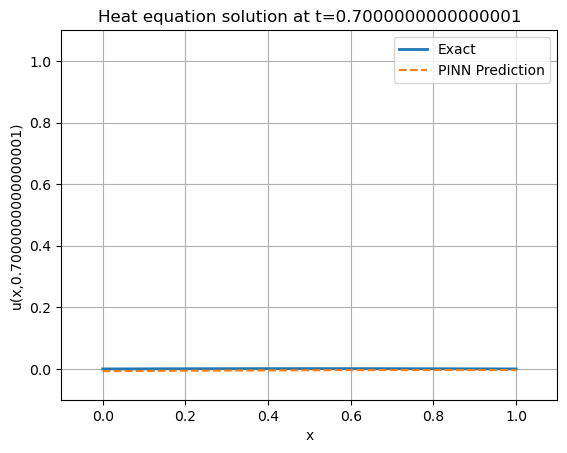

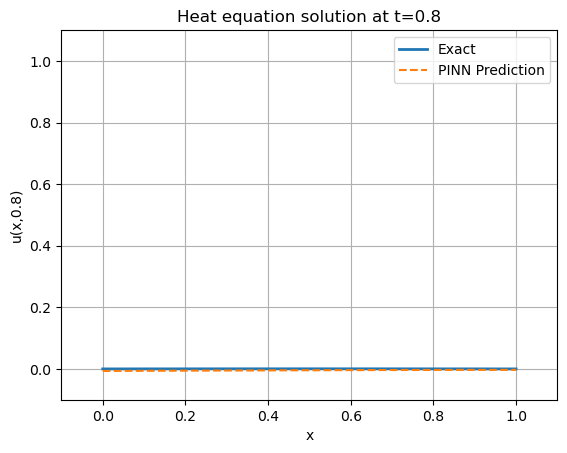

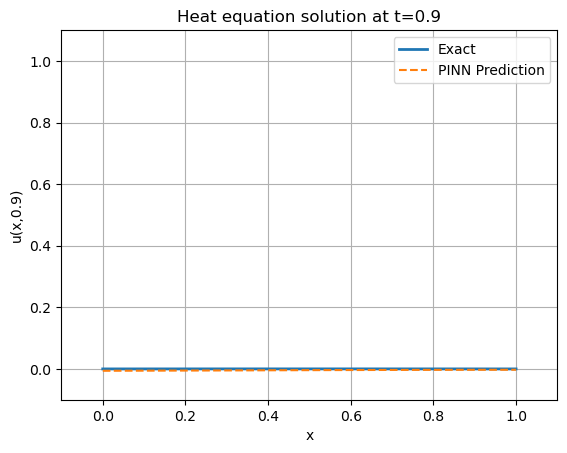

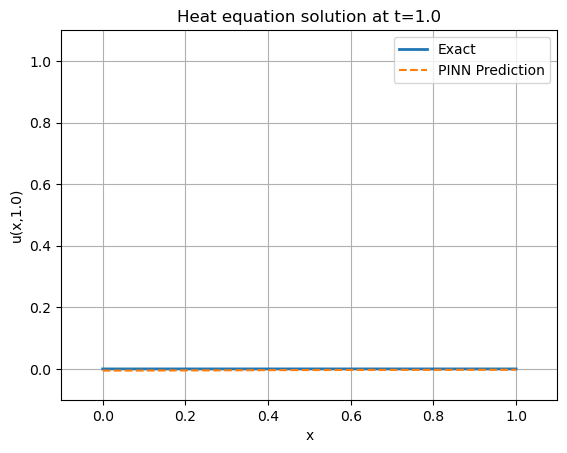

In [749]:
## Plot many time steps to compare to actual solution

for k in np.linspace(0,1,11):
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
    t_test = torch.full_like(x_test, k)
    u_pred = model(x_test, t_test).detach().numpy()
    u_exact = np.exp(-np.pi**2 * k) * np.sin(np.pi * x_test)
    
    plt.plot(x_test, u_exact, label="Exact", linewidth=2)
    plt.plot(x_test, u_pred, '--', label="PINN Prediction")
    plt.xlabel("x")
    plt.ylabel(f"u(x,{k})")
    plt.title(f"Heat equation solution at t={k}")
    plt.legend()
    plt.xlim([-.1,1.1])
    plt.ylim([-.1,1.1])
    plt.grid(True)
    plt.show()

# LOOKS GREAT!!!

In [695]:
## Let's try to figure out 3D surface plotting
from mpl_toolkits.mplot3d import Axes3D # for 3D axes?

## Plot for inputted TRAINED neural net model for chosen elevation and azimuthal angle for plot viewing
# defaults elev=30, azim=-60

def NNHeatPlot(elev,azim):
    # first define x and t values over which we plot
    x = torch.linspace(0, L, 100).reshape(-1, 1)
    t = torch.linspace(0, T, 100).reshape(-1, 1)
    
    # list comprehension evaluates model for all x at each time value
    U = torch.stack([model(x,torch.ones_like(x)*n) for n in t])
    
    # convert x and t into meshgrid for plotting
    x, t = np.meshgrid(x,t)
    
    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, t, U.detach().numpy().reshape(-1,100), cmap='plasma')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
    
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("t")
    ax.set_zlabel("u(x,t)")
    plt.title("Neural network heat equation solution u_NN(x,t)")
    ax.view_init(elev, azim) # default elev=30, azim=-60
    #plt.legend()
    #plt.xlim([-.1,1.1])
    #plt.ylim([-.1,0.4])
    #plt.grid(True)
    plt.show()

def ActualHeatPlot(elev,azim):
    x = torch.linspace(0, L, 100).reshape(-1, 1)
    t = torch.linspace(0, T, 100).reshape(-1, 1)
    x, t = np.meshgrid(x,t)
    U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
    
    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, t, U_actual, cmap='plasma')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
    
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("t")
    ax.set_zlabel("u(x,t)")
    plt.title("Actual heat equation solution u(x,t)=exp(-pi^2 t)sin(pi x)")
    ax.view_init(elev, azim) # default elev=30, azim=-60
    #plt.legend()
    #plt.xlim([-.1,1.1])
    #plt.ylim([-.1,0.4])
    #plt.grid(True)
    plt.show()


In [697]:
## In this section we run our finite difference scheme

# define grid values
N = 20001 # total time points
M = 100 # total spatial points (one direction)
T = 1 # time boundary
L = 1 # spatial boundary
dt = T/N
dx = R/M

# creates grid vectors
t = (np.arange(N+1))*dt
#print(t)
#print(np.shape(t))
#x = (np.arange(-(N-1),N+1))*dx+L
x = np.arange(0,M+1)*dx

# now create the tridiagonal matrix for discrete Laplacian
a = 1  # Subdiagonal
b = -2   # Main diagonal
c = 1  # Superdiagonal

# Create diagonals - 2*N long bc of structure of grid
#main_diag = b * np.ones(2*N) #if [-L,L]
#upper_diag = c * np.ones(2*N - 1) #if [-L,L]
#lower_diag = a * np.ones(2*N - 1) #if [-L,L]

main_diag = b * np.ones(M+1)
upper_diag = c * np.ones(M)
lower_diag = a * np.ones(M)

# Create the tridiagonal matrix
Lh = np.diag(main_diag) + np.diag(upper_diag, k=1) + np.diag(lower_diag, k=-1)
#L[0,-1] = 1 #periodic
#L[-1,0] = 1 #periodic
Lh = (1/(dx**2))*Lh # scale by dx^2

print(dt / dx**2)
assert dt / dx**2 < 0.5, "Stability condition not met"


u_prev = np.sin(np.pi*x)

# initialize matrix to store solution
u = []

for n in t:
    u_next = u_prev + dt * (Lh @ u_prev)
    u.append(u_next) # store result
    u_prev = u_next # reassign

u_mat = np.array(u) # converts history to an array


0.4999750012499375


In [699]:
## ALL PLOTTING FUNCTIONS

## Let's try to figure out 3D surface plotting
from mpl_toolkits.mplot3d import Axes3D # for 3D axes?

## Plot for inputted TRAINED neural net model for chosen elevation and azimuthal angle for plot viewing
# defaults elev=30, azim=-60

def NNHeatPlot(elev,azim):
    # first define x and t values over which we plot
    x = torch.linspace(0, L, M+1).reshape(-1, 1)
    t = torch.linspace(0, T, N+1).reshape(-1, 1)
    
    # list comprehension evaluates model for all x at each time value
    U = torch.stack([model(x,torch.ones_like(x)*n) for n in t])
    
    # convert x and t into meshgrid for plotting
    x, t = np.meshgrid(x,t)
    
    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, t, U.detach().numpy().reshape(-1,M+1), cmap='plasma')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
    
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("t")
    ax.set_zlabel("u(x,t)")
    plt.title("Neural network heat equation solution u_NN(x,t)")
    ax.view_init(elev, azim) # default elev=30, azim=-60
    #plt.legend()
    #plt.xlim([-.1,1.1])
    #plt.ylim([-.1,0.4])
    #plt.grid(True)
    plt.show()

def ActualHeatPlot(elev,azim):
    x = torch.linspace(0, L, M+1).reshape(-1, 1)
    t = torch.linspace(0, T, N+1).reshape(-1, 1)
    x, t = np.meshgrid(x,t)
    U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
    
    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, t, U_actual, cmap='plasma')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
    
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("t")
    ax.set_zlabel("u(x,t)")
    plt.title("Actual heat equation solution u(x,t)=exp(-pi^2 t)sin(pi x)")
    ax.view_init(elev, azim) # default elev=30, azim=-60
    #plt.legend()
    #plt.xlim([-.1,1.1])
    #plt.ylim([-.1,0.4])
    #plt.grid(True)
    plt.show()

def FDHeatPlot(elev,azim):
    #M = 100 # total time points
    #N = 100 # total spatial points (one direction)
    T = 1 # time boundary
    L = 1 # spatial boundary
    dt = T/N
    dx = R/M
    
    # creates grid vectors
    t = (np.arange(N+1))*dt
    #x = (np.arange(-(N-1),N+1))*dx+L #use if [-L,L]
    x = np.arange(0,M+1)*dx
    x, t = np.meshgrid(x,t)
    
    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, t, u_mat, cmap='plasma')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
    
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("t")
    ax.set_zlabel("u(x,t)")
    plt.title("Finite Difference heat equation solution u_FD(x,t)")
    ax.view_init(elev, azim) # default elev=30, azim=-60
    #plt.legend()
    #plt.xlim([-.1,1.1])
    #plt.ylim([-.1,0.4])
    #plt.grid(True)
    plt.show()

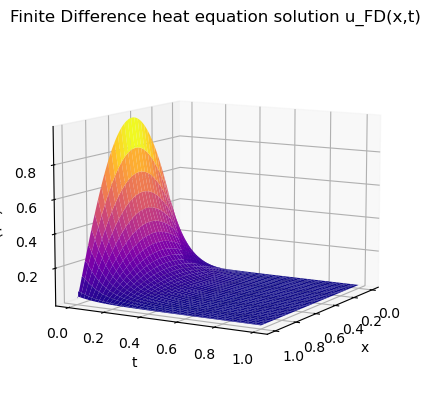

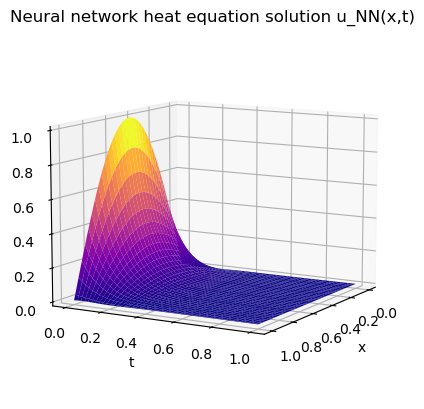

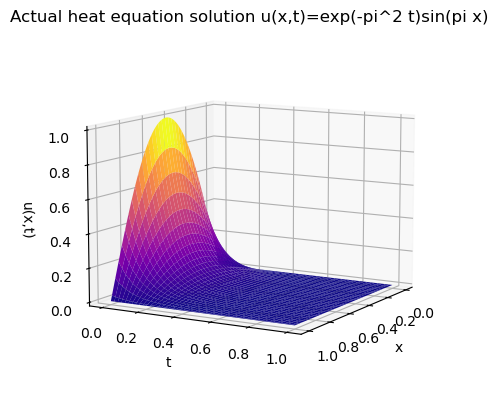

In [701]:
## Plot the Neural Net, Finite Difference, and acutal solutions:

# select elev = 10, azim = 30
elev=10
azim=30

FDHeatPlot(elev,azim)
NNHeatPlot(elev,azim)
ActualHeatPlot(elev,azim)

## Gives us a good heuristic sense that our model is correct!!

In [703]:
## Now that we have a sense for how things look, lets do some error comparisons
#print(U_actual - U)
#print(np.linalg.norm(vector))


def NN_residual():
    # compute the residual for neural network output
    
    # first define x and t values over which we plot
    x = torch.linspace(0, L, M+1).reshape(-1, 1)
    t = torch.linspace(0, T, N+1).reshape(-1, 1)
    
    # list comprehension evaluates model for all x at each time value
    U = torch.stack([model(x,torch.ones_like(x)*n) for n in t])
    
    # convert x and t into meshgrid for plotting
    x, t = np.meshgrid(x,t)
    
    U = U.detach().numpy().reshape(-1,M+1)
    U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

    U_res = U - U_actual
    #return np.linalg.norm(U_res,np.inf) # max row sum
    #return np.max(np.abs(U_resNN)) # max single value
    return np.mean(U_res**2)

    #return U_res

def FD_residual():
    # compute the residual for neural network output
    
    #M = 10000 # total time points
    #N = 50 # total spatial points (one direction)
    T = 1 # time boundary
    L = 1 # spatial boundary
    dt = T/N
    dx = R/M
    
    # creates grid vectors
    t = (np.arange(N+1))*dt
    #x = (np.arange(-(N-1),N+1))*dx+L #use if [-L,L]
    x = np.arange(0,M+1)*dx
    x, t = np.meshgrid(x,t)
    #print(x)
    #print(t)
    U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
    #print(U_actual[0,])
    #print(u_mat[0,])

    U_res = u_mat - U_actual
    #return U_res
    #return np.linalg.norm(U_res,np.inf) # max row sum
    #return np.max(np.abs(U_resFD)) # max single value
    return np.mean(U_res**2)
    
    

    

In [705]:
print(f"Neural network residual mean squared error: {NN_residual()}")
print(f"Finite difference residual mean squared error: {FD_residual()}")

Neural network residual infinity norm: 7.953515705594327e-06
Finite difference residual infinity norm: 2.7931375996184858e-05


In [783]:
## Now that we have done some preliminary analysis, let's see if we can mess around with the neural network and test its accuracy:

## EXPERIMENT 1: Test batch size
# The goal of this experiment is to test how changing the batch size relative to the training set affects the optimization of the network
# Hope to get small batch that runs quick but doesn't give too much error.
import time

# list to store residuals
res = []

# initialize model
hidden_units = 100

# select an optimizer, will use Adam: 
lr = 1e-3 # learning rate

max_epochs = 10000 # maximum number of iterations
tol = 1e-4 # error tolerance to stop GD before reaching max_epochs

for i in range(10):
    # initialize model
    model = Heat_PINN(hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # training data parameters
    N_I = 100
    N_B = 100
    N_L = 1000
    
    # training parameters
    batch_size_I = N_I//(i+1)
    batch_size_B = N_B//(i+1)
    batch_size_L = N_L//(i+1)
    
    start = time.perf_counter() 
    train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, 0)

    #NNHeatPlot(elev,azim)

    res_trial = NN_residual()
    end = time.perf_counter()
    total_t = end-start
    
    res.append([res_trial, total_t])


100
Network converged to specified tolerance tol = 0.0001
Final epoch: 3562
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 3549
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5691
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5286
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5474
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5505
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 7630
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 9112
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 8651
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 9612


In [831]:
# EXPERIMENT 2: mess with training data size

# initialize model
hidden_units = 100

# select an optimizer, will use Adam: 
lr = 1e-3 # learning rate

res2 = []

#U = torch.stack([model(x,torch.ones_like(x)*n) for n in t])

max_epochs = 10000 # maximum number of iterations
tol = 1e-4 # error tolerance to stop GD before reaching max_epochs

for i in range(10):
    # initialize model
    model = Heat_PINN(hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # training data parameters
    N_I = 10*(i+1)
    N_B = 10*(i+1)
    N_L = 100*(i+1)
    
    # training parameters
    batch_size_I = N_I//5
    batch_size_B = N_B//5
    batch_size_L = N_L//5
    
    start = time.perf_counter()     
    train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, 0)

    #NNHeatPlot(elev,azim)

    res2_trial = NN_residual()
    end = time.perf_counter()
    total_t = end-start
    
    res2.append([res2_trial, total_t])


## Section works!



10
Network converged to specified tolerance tol = 0.0001
Final epoch: 8660
20
30
40
50
Network converged to specified tolerance tol = 0.0001
Final epoch: 6690
60
Network converged to specified tolerance tol = 0.0001
Final epoch: 5748
70
Network converged to specified tolerance tol = 0.0001
Final epoch: 6329
80
Network converged to specified tolerance tol = 0.0001
Final epoch: 6103
90
Network converged to specified tolerance tol = 0.0001
Final epoch: 6059
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 6509


In [825]:
# EXPERIMENT 3: change hidden layer size

res3 = []

for i in range(10):

    # initialize model
    hidden_units = 10*(i+1)
    
    # learning parameters: 
    lr = 1e-3 # learning rate
    max_epochs = 10000 # maximum number of iterations
    tol = 1e-4 # error tolerance to stop GD before reaching max_epochs
    
    # initialize model
    model = Heat_PINN(hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr)
        
    # training data parameters
    N_I = 50
    N_B = 50
    N_L = 500
        
    # training parameters
    batch_size_I = N_I//5
    batch_size_B = N_B//5
    batch_size_L = N_L//5
        
    start = time.perf_counter()      
    train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, 0)
    
    #NNHeatPlot(elev,azim)

    res3_trial = NN_residual()
    end = time.perf_counter()
    total_t = end-start
    
    res3.append([res3_trial, total_t])


## Section works!

100
100
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 8791
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 6795
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 7749
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 4490
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5266
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 6982
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 5505
100
Network converged to specified tolerance tol = 0.0001
Final epoch: 4552


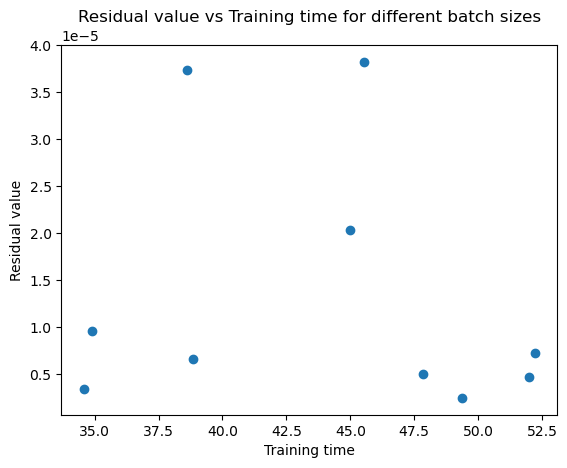

In [805]:
# FOR EXPERIMENT 1
res_values = [r[0] for r in res]
t_values = [r[1] for r in res]

# Scatter plot
plt.scatter(t_values, res_values)
plt.xlabel('Training time')
plt.ylabel('Residual value')
plt.title('Residual value vs Training time for different batch sizes')
#plt.grid(True)
#plt.legend()


#for i, (x_i, y_i) in enumerate(res):
#don’t     plt.text(x_i + 0.1, y_i + 0.1, f"P{i}", fontsize=9)

plt.show()



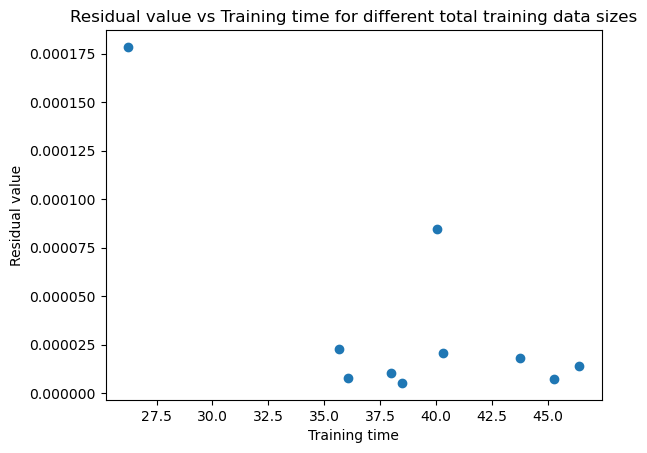

In [833]:
# FOR EXPERIMENT 2
res2_values = [r[0] for r in res2]
t_values = [r[1] for r in res2]

# Scatter plot
plt.scatter(t_values, res2_values)
plt.xlabel('Training time')
plt.ylabel('Residual value')
plt.title('Residual value vs Training time for different total training data sizes')
#plt.grid(True)
#plt.legend()


#for i, (x_i, y_i) in enumerate(res):
#don’t     plt.text(x_i + 0.1, y_i + 0.1, f"P{i}", fontsize=9)

plt.show()

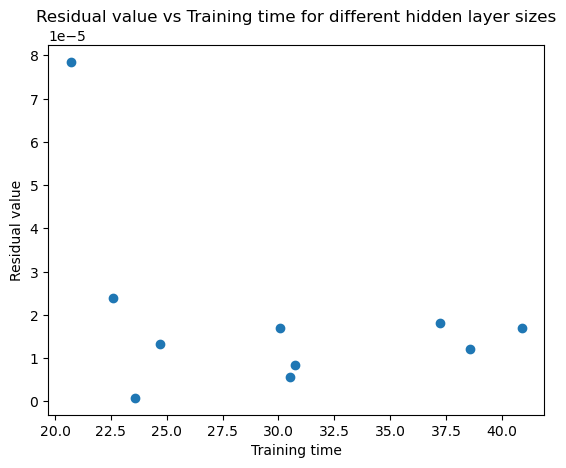

In [827]:
# FOR EXPERIMENT 3
res3_values = [r[0] for r in res3]
t_values = [r[1] for r in res3]

# Scatter plot
plt.scatter(t_values, res3_values)
plt.xlabel('Training time')
plt.ylabel('Residual value')
plt.title('Residual value vs Training time for different hidden layer sizes')
#plt.grid(True)
#plt.legend()


#for i, (x_i, y_i) in enumerate(res):
#don’t     plt.text(x_i + 0.1, y_i + 0.1, f"P{i}", fontsize=9)

plt.show()

In [681]:
## EXTRANEOUS EXPERIMENT: NOT INCLUDED IN PROJECT WRITEUP

## PLOT ERROR OVER TIME

# first define x and t values over which we plot
x = torch.linspace(0, L, M+1).reshape(-1, 1)
t = torch.linspace(0, T, N+1).reshape(-1, 1)
    
# list comprehension evaluates model for all x at each time value
U = torch.stack([model(x,torch.ones_like(x)*n) for n in t])
    
# convert x and t into meshgrid for plotting
x, t = np.meshgrid(x,t)
    
U = U.detach().numpy().reshape(-1,M+1)
U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

U_resNN = U - U_actual
U_resFD = u_mat - U_actual

#NN_norms = [np.linalg.norm(U_resNN[i,],np.inf) for i in range(N+1)]
#FD_norms = [np.linalg.norm(U_resFD[i,],np.inf) for i in range(N+1)]

NN_norms = [np.mean(U_resNN[0:i+1,]**2) for i in range(N+1)]
FD_norms = [np.mean(U_resFD[0:i+1,]**2) for i in range(N+1)]



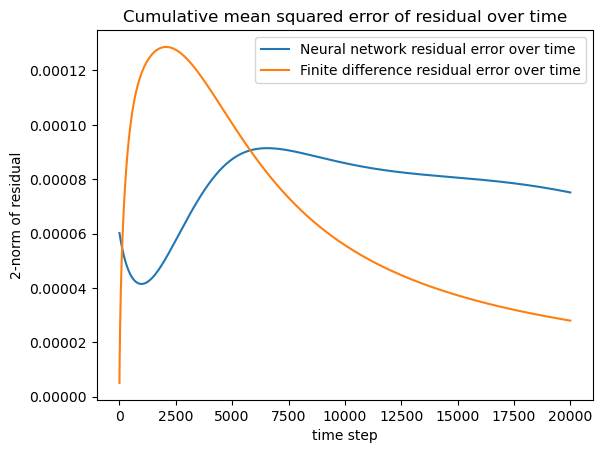

In [683]:
# Plot norms over time
plt.plot(NN_norms, label = "Neural network residual error over time")
plt.plot(FD_norms, label = "Finite difference residual error over time")
plt.xlabel("time step")
plt.ylabel("2-norm of residual")
plt.title("Cumulative mean squared error of residual over time")
plt.legend()
